In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import wandb
import tempfile
import os
from models.normalizing_flow import HierarchicalNormalizingFlowSB
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn


In [47]:
from train_flow_sb import unflatten, object_from_config

In [48]:
api = wandb.Api()

In [49]:
# run = api.run('druhe/gw-src/ntnb1v04')
run = api.run('druhe/gw-src/2h8k9f03')



In [50]:
config = unflatten(run.config)

In [51]:
config['model']['sb_weight']
config['model']['prior_weight']

1

In [52]:
dataset = object_from_config(config, key='dataset')
dataset = dataset(**config['dataset'])

In [53]:
flows = object_from_config(config, key='flow')(**config['flow'])

In [10]:
checkpoints = [f for f in run.files() if f.name.endswith('.ckpt')]

In [11]:
tempdir = tempfile.TemporaryDirectory()

In [12]:
ckpt = checkpoints[-1]

In [13]:
ckpt_path = ckpt.download(root=tempdir.name, replace=True)

In [14]:
model = object_from_config(config, key='model')

In [15]:
model = model.load_from_checkpoint(ckpt_path.name, flows=flows, dataset=dataset, sb_weight=0, prior_weight=1)




INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/d3/x840qlg17x1f92cnsrkq62fw0000gn/T/tmps56c6_bf
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/d3/x840qlg17x1f92cnsrkq62fw0000gn/T/tmps56c6_bf/_remote_module_non_sriptable.py


In [16]:
import hamiltorch

from torch.nn.utils import _stateless


In [17]:
def flatten_params(parameters):
    """
    flattens all parameters into a single column vector. Returns the dictionary to recover them
    :param: parameters: a generator or list of all the parameters
    :return: a dictionary: {"params": [#params, 1],
    "indices": [(start index, end index) for each param] **Note end index in uninclusive**

    """
    l = [torch.flatten(p) for p in parameters]
    indices = []
    s = 0
    for p in l:
        size = p.shape[0]
        indices.append((s, s+size))
        s += size
    flat = torch.cat(l).view(-1, 1)
    return flat, indices


def unflatten_params(flat_params, indices, model):
    """
    Gives a list of recovered parameters from their flattened form
    :param flat_params: [#params, 1]
    :param indices: a list detaling the start and end index of each param [(start, end) for param]
    :param model: the model that gives the params with correct shapes
    :return: the params, reshaped to the ones in the model, with the same order as those in the model
    """
    l = [flat_params[s:e] for (s, e) in indices]
    for i, p in enumerate(model.parameters()):
        l[i] = l[i].view(*p.shape)
    return tuple(nn.Parameter(p) for p in l)


In [18]:
params_flat, indices = flatten_params(model.parameters())
names = list(n for n, _ in model.named_parameters())


In [231]:
model=model.double()

params_init = hamiltorch.util.flatten(model).clone().double()


In [232]:
gw_loader, sel_loader = dataset.train_dataloader()

In [233]:
gw_iter = iter(gw_loader)

In [234]:
likelihoods = []
priors = []
total = []
i = 0
def log_prob(params, y=None):
    global gw_iter
    global sel_iter
    global likelihoods
    global i 
    try:
        gw_batch = next(gw_iter)
#         sel_batch = next(sel_iter)
    except StopIteration:
        gw_iter = iter(gw_loader)
#         sel_iter = iter(sel_loader)
        gw_batch = next(gw_iter)
#         sel_batch = next(sel_iter)

    gw_batch[0] = gw_batch[0].double()
#     sel_batch[0] = sel_batch[0].double()
    
    prior = torch.distributions.Normal(params_init, 5).log_prob(params)

    params = unflatten_params(params, indices, model)
            
    out: torch.Tensor = _stateless.functional_call(model, {n: p for n, p in zip(names, params)}, gw_batch)    
    ll = prior.sum() / len(out) + out.mean()
    
    if i % 20 == 0:
        likelihoods.append(out.mean().item())
        priors.append(prior.sum().item() / len(out))
        total.append(likelihoods[-1] + priors[-1])
    i += 1

#     print(out.mean().item())
    return ll




In [235]:

N = 64
burn = 64
N_nuts = N + burn
step_size = 1e-3
L = 20

samples = hamiltorch.sample(
    log_prob, 
    params_init=params_init, 
    num_samples=N_nuts, 
    num_steps_per_sample=L, 
    step_size=step_size, 
    burn=burn, 
    desired_accept_rate=0.8,
    sampler=hamiltorch.Sampler.HMC_NUTS,
    debug=True)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
Step: 0, Current Hamiltoninian: 54.65707616128586, Proposed Hamiltoninian: 66.45200676647806
REJECT
Step: 1, Current Hamiltoninian: 58.73148818136551, Proposed Hamiltoninian: 96.9393086028025
REJECT
Step: 2, Current Hamiltoninian: 64.33982198264023, Proposed Hamiltoninian: 65.50785961257796
Accept rho: -1.1680376299377286
Step: 3, Current Hamiltoninian: 63.20736092419111, Proposed Hamiltoninian: 63.34510484787605
REJECT
Step: 4, Current Hamiltoninian: 60.42142832565065, Proposed Hamiltoninian: 60.52149861335133
Accept rho: -0.1000702877006816
Step: 5, Current Hamiltoninian: 52.812042526496576, Proposed Hamiltoninian: 52.61800938721401
Accept rho: 0.0
Step: 6, Current Hamiltoninian: 66.31688298546365, Proposed Hamiltoninian: 66.16589035348181
Accept rho: 0.0
Step: 7, Current Hamiltoninian: 49.04723554449391, Proposed Hamiltoninian: 49.29937192515641
Accept rho: -0.2521363

Step: 70, Current Hamiltoninian: 66.13625452701882, Proposed Hamiltoninian: 65.06354693572715
Accept rho: 0.0
Step: 71, Current Hamiltoninian: 52.58192122676983, Proposed Hamiltoninian: 52.44123592507147
Accept rho: 0.0
Step: 72, Current Hamiltoninian: 66.54130851100741, Proposed Hamiltoninian: 66.52866998906956
Accept rho: 0.0
Step: 73, Current Hamiltoninian: 70.1886084033715, Proposed Hamiltoninian: 69.5631297579566
Accept rho: 0.0
Step: 74, Current Hamiltoninian: 51.2598427395974, Proposed Hamiltoninian: 50.4806975396523
Accept rho: 0.0
Step: 75, Current Hamiltoninian: 51.37985751069778, Proposed Hamiltoninian: 52.34717650590208
REJECT
Step: 76, Current Hamiltoninian: 60.92888315607852, Proposed Hamiltoninian: 61.058542255348456
Accept rho: -0.12965909926993646
Step: 77, Current Hamiltoninian: 66.19819931447665, Proposed Hamiltoninian: 66.27543283259998
REJECT
Step: 78, Current Hamiltoninian: 61.72508670459267, Proposed Hamiltoninian: 62.63976257372576
REJECT
Step: 79, Current Hamil

In [236]:
samples = torch.stack(samples)



In [237]:
axes_names = []
axes = []

for n, ax in dataset.grid.items():
    axes_names.append(n)
    axes.append(ax)

d = dataset.dimensionality
m1, m2, z, chi = np.stack(np.meshgrid(*axes, indexing="ij")).reshape(d, -1)

resolutions = [len(ax) for ax in axes]

input = np.stack([m1, m2, z, chi], axis=-1)
input = torch.from_numpy(input)

In [238]:
def functional_call(model, flat_params):
    
    params = unflatten_params(flat_params, indices, model)

    out: torch.Tensor = _stateless.functional_call(model, {n: p for n, p in zip(names, params)}, input)    
    return out

In [239]:
with torch.no_grad():
    logprob = functional_call(model, params_init)
prob = logprob.exp().view(*resolutions)


Got 2D data, reshaping to 3D


In [240]:
len(likelihoods)

148

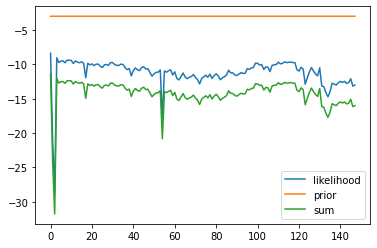

In [241]:
plt.plot(likelihoods, label='likelihood')
plt.plot(priors, label='prior')
plt.plot(total, label='sum')
plt.legend()

# plt.ylim(-20, -5)

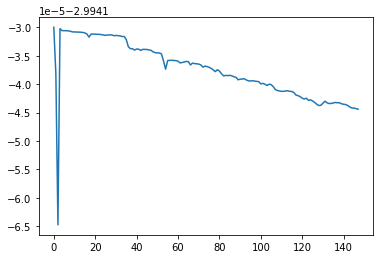

In [242]:
plt.plot(priors)


In [243]:
pm1m2 = prob.sum((2, 3))

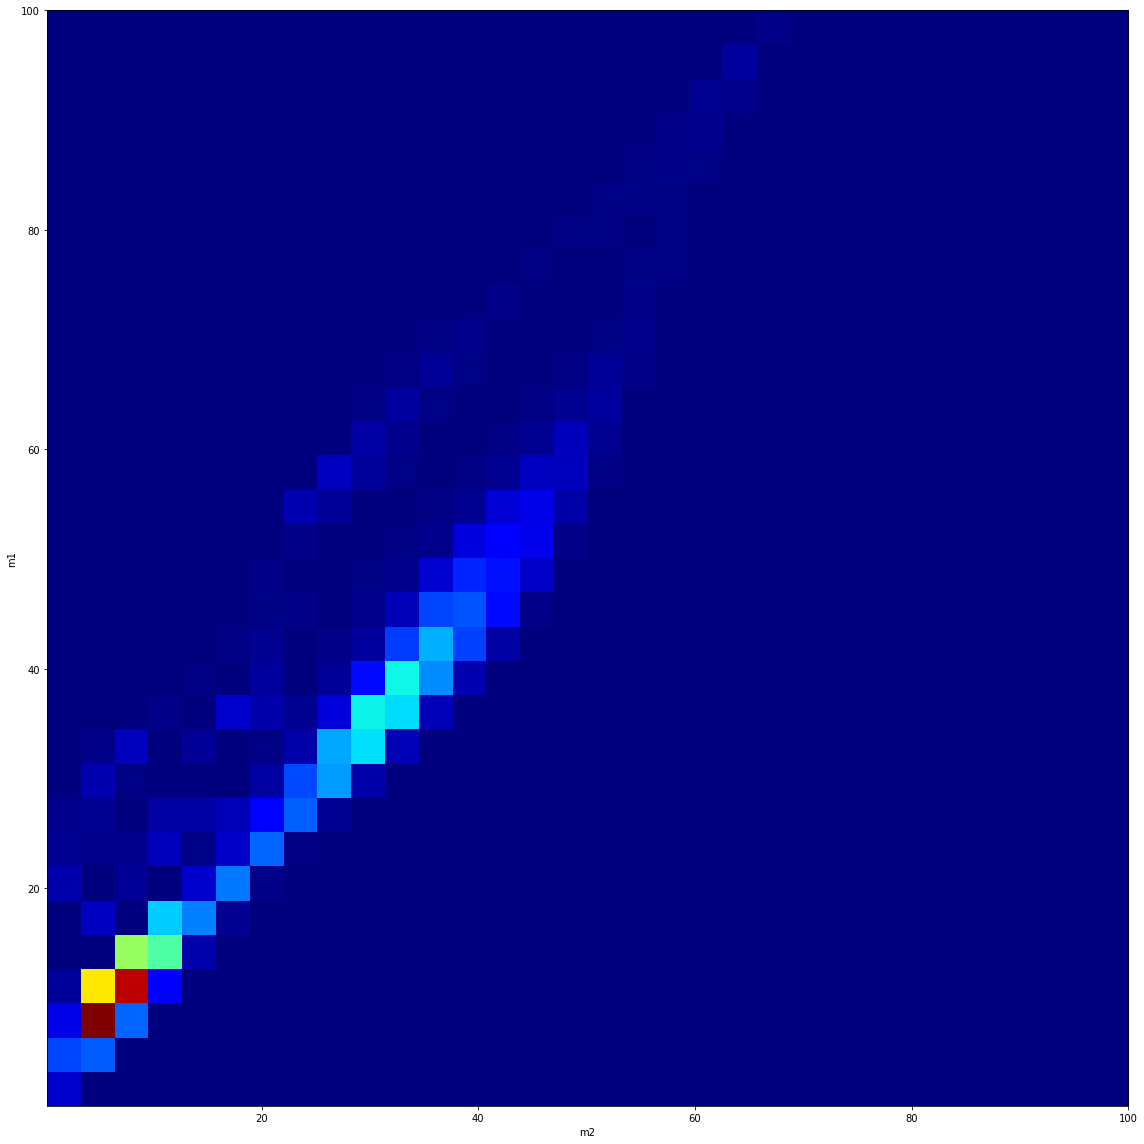

In [244]:
fig = plt.figure(figsize=(16, 16), facecolor="white")
plt.imshow(
    pm1m2,
    cmap="jet",
    origin="lower",
    extent=(
        axes[1][0],
        axes[1][-1],
        axes[0][0],
        axes[0][-1],
    ),  # origin='lower' changes the order
    aspect="auto",
)

plt.xlabel(axes_names[1])  # origin='lower' changes the order
plt.ylabel(axes_names[0])
plt.tight_layout()

In [245]:
pm1= prob.sum((1, 2, 3))

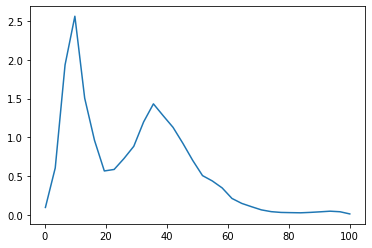

In [246]:
plt.plot(axes[0], pm1)
# plt.yscale('log')

In [247]:
import tqdm

In [248]:
probs = []
for sample in tqdm.tqdm(samples):
    with torch.no_grad():
        logprob = functional_call(model, sample)
    prob = logprob.exp().view(*resolutions)
    probs.append(prob)

  0%|                                                                                                                                                                                                                  | 0/64 [00:00<?, ?it/s]

Got 2D data, reshaping to 3D


  2%|███▏                                                                                                                                                                                                      | 1/64 [00:00<00:30,  2.07it/s]

Got 2D data, reshaping to 3D


  3%|██████▎                                                                                                                                                                                                   | 2/64 [00:00<00:28,  2.16it/s]

Got 2D data, reshaping to 3D


  5%|█████████▍                                                                                                                                                                                                | 3/64 [00:01<00:28,  2.18it/s]

Got 2D data, reshaping to 3D


  6%|████████████▋                                                                                                                                                                                             | 4/64 [00:01<00:27,  2.20it/s]

Got 2D data, reshaping to 3D


  8%|███████████████▊                                                                                                                                                                                          | 5/64 [00:02<00:27,  2.17it/s]

Got 2D data, reshaping to 3D


  9%|██████████████████▉                                                                                                                                                                                       | 6/64 [00:02<00:26,  2.20it/s]

Got 2D data, reshaping to 3D


 11%|██████████████████████                                                                                                                                                                                    | 7/64 [00:03<00:28,  2.03it/s]

Got 2D data, reshaping to 3D


 12%|█████████████████████████▎                                                                                                                                                                                | 8/64 [00:03<00:26,  2.10it/s]

Got 2D data, reshaping to 3D


 14%|████████████████████████████▍                                                                                                                                                                             | 9/64 [00:04<00:25,  2.16it/s]

Got 2D data, reshaping to 3D


 16%|███████████████████████████████▍                                                                                                                                                                         | 10/64 [00:04<00:24,  2.21it/s]

Got 2D data, reshaping to 3D


 17%|██████████████████████████████████▌                                                                                                                                                                      | 11/64 [00:05<00:24,  2.16it/s]

Got 2D data, reshaping to 3D


 19%|█████████████████████████████████████▋                                                                                                                                                                   | 12/64 [00:05<00:24,  2.14it/s]

Got 2D data, reshaping to 3D


 20%|████████████████████████████████████████▊                                                                                                                                                                | 13/64 [00:06<00:24,  2.12it/s]

Got 2D data, reshaping to 3D


 22%|███████████████████████████████████████████▉                                                                                                                                                             | 14/64 [00:06<00:22,  2.18it/s]

Got 2D data, reshaping to 3D


 23%|███████████████████████████████████████████████                                                                                                                                                          | 15/64 [00:06<00:22,  2.22it/s]

Got 2D data, reshaping to 3D


 25%|██████████████████████████████████████████████████▎                                                                                                                                                      | 16/64 [00:07<00:21,  2.25it/s]

Got 2D data, reshaping to 3D


 27%|█████████████████████████████████████████████████████▍                                                                                                                                                   | 17/64 [00:07<00:20,  2.27it/s]

Got 2D data, reshaping to 3D


 28%|████████████████████████████████████████████████████████▌                                                                                                                                                | 18/64 [00:08<00:21,  2.17it/s]

Got 2D data, reshaping to 3D


 30%|███████████████████████████████████████████████████████████▋                                                                                                                                             | 19/64 [00:08<00:22,  2.00it/s]

Got 2D data, reshaping to 3D


 31%|██████████████████████████████████████████████████████████████▊                                                                                                                                          | 20/64 [00:09<00:21,  2.01it/s]

Got 2D data, reshaping to 3D


 33%|█████████████████████████████████████████████████████████████████▉                                                                                                                                       | 21/64 [00:09<00:21,  1.98it/s]

Got 2D data, reshaping to 3D


 34%|█████████████████████████████████████████████████████████████████████                                                                                                                                    | 22/64 [00:10<00:20,  2.03it/s]

Got 2D data, reshaping to 3D


 36%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 23/64 [00:10<00:19,  2.09it/s]

Got 2D data, reshaping to 3D


 38%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 24/64 [00:11<00:18,  2.14it/s]

Got 2D data, reshaping to 3D


 39%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 25/64 [00:11<00:17,  2.18it/s]

Got 2D data, reshaping to 3D


 41%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 26/64 [00:12<00:17,  2.21it/s]

Got 2D data, reshaping to 3D


 42%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 27/64 [00:12<00:16,  2.24it/s]

Got 2D data, reshaping to 3D


 44%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 28/64 [00:13<00:16,  2.24it/s]

Got 2D data, reshaping to 3D


 45%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 29/64 [00:13<00:15,  2.25it/s]

Got 2D data, reshaping to 3D


 47%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 30/64 [00:13<00:15,  2.25it/s]

Got 2D data, reshaping to 3D


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 31/64 [00:14<00:14,  2.23it/s]

Got 2D data, reshaping to 3D


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 32/64 [00:14<00:14,  2.23it/s]

Got 2D data, reshaping to 3D


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 33/64 [00:15<00:14,  2.17it/s]

Got 2D data, reshaping to 3D


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 34/64 [00:15<00:13,  2.18it/s]

Got 2D data, reshaping to 3D


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 35/64 [00:16<00:13,  2.09it/s]

Got 2D data, reshaping to 3D


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 36/64 [00:16<00:13,  2.06it/s]

Got 2D data, reshaping to 3D


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 37/64 [00:17<00:12,  2.10it/s]

Got 2D data, reshaping to 3D


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 38/64 [00:17<00:12,  2.07it/s]

Got 2D data, reshaping to 3D


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 39/64 [00:18<00:12,  1.96it/s]

Got 2D data, reshaping to 3D


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 40/64 [00:18<00:11,  2.01it/s]

Got 2D data, reshaping to 3D


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 41/64 [00:19<00:11,  2.05it/s]

Got 2D data, reshaping to 3D


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 42/64 [00:19<00:10,  2.01it/s]

Got 2D data, reshaping to 3D


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 43/64 [00:20<00:10,  1.94it/s]

Got 2D data, reshaping to 3D


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 44/64 [00:20<00:10,  1.88it/s]

Got 2D data, reshaping to 3D


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 45/64 [00:21<00:09,  1.91it/s]

Got 2D data, reshaping to 3D


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 46/64 [00:21<00:09,  1.88it/s]

Got 2D data, reshaping to 3D


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 47/64 [00:22<00:09,  1.85it/s]

Got 2D data, reshaping to 3D


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 48/64 [00:23<00:08,  1.87it/s]

Got 2D data, reshaping to 3D


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 49/64 [00:23<00:07,  1.92it/s]

Got 2D data, reshaping to 3D


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 50/64 [00:23<00:06,  2.01it/s]

Got 2D data, reshaping to 3D


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 51/64 [00:24<00:06,  2.07it/s]

Got 2D data, reshaping to 3D


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 52/64 [00:24<00:05,  2.12it/s]

Got 2D data, reshaping to 3D


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 53/64 [00:25<00:05,  2.16it/s]

Got 2D data, reshaping to 3D


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 54/64 [00:25<00:04,  2.20it/s]

Got 2D data, reshaping to 3D


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 55/64 [00:26<00:04,  2.22it/s]

Got 2D data, reshaping to 3D


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 56/64 [00:26<00:03,  2.22it/s]

Got 2D data, reshaping to 3D


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 57/64 [00:27<00:03,  2.23it/s]

Got 2D data, reshaping to 3D


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 58/64 [00:27<00:02,  2.25it/s]

Got 2D data, reshaping to 3D


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 59/64 [00:27<00:02,  2.26it/s]

Got 2D data, reshaping to 3D


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 60/64 [00:28<00:01,  2.25it/s]

Got 2D data, reshaping to 3D


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 61/64 [00:28<00:01,  2.26it/s]

Got 2D data, reshaping to 3D


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 62/64 [00:29<00:00,  2.26it/s]

Got 2D data, reshaping to 3D


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 63/64 [00:29<00:00,  2.25it/s]

Got 2D data, reshaping to 3D


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:30<00:00,  2.12it/s]


In [249]:
probs = torch.stack(probs)

In [250]:
probs.shape

torch.Size([64, 32, 32, 32, 32])

In [251]:
m1 = probs.sum((2, 3, 4)).numpy()

In [252]:
m1_med = np.median(m1, axis=0)

In [253]:
m1_005 = np.percentile(m1, 5, axis=0)
m1_095 = np.percentile(m1, 95, axis=0)

(1e-05, 3)

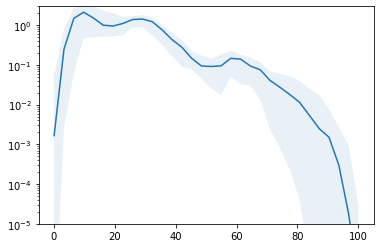

In [256]:
plt.plot(axes[0], m1_med)
plt.fill_between(axes[0], m1_005, m1_095, alpha=0.1)
plt.yscale('log')
plt.ylim((1e-5, 3))

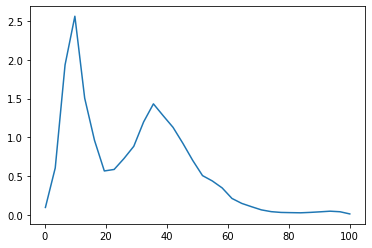

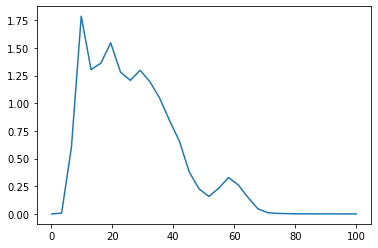

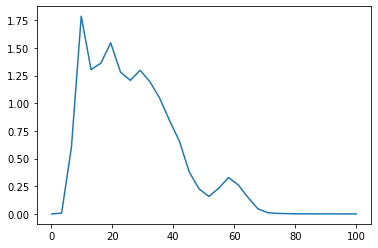

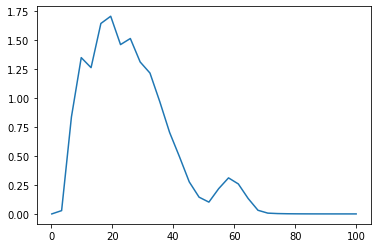

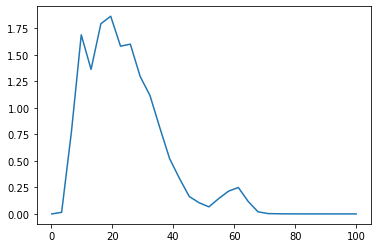

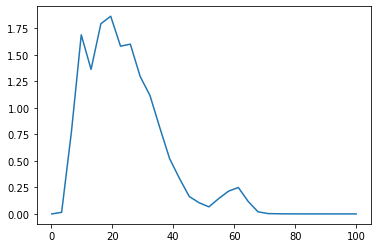

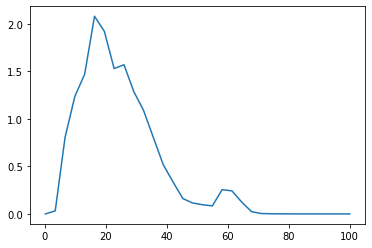

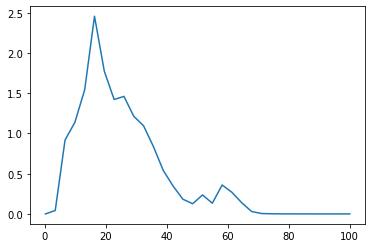

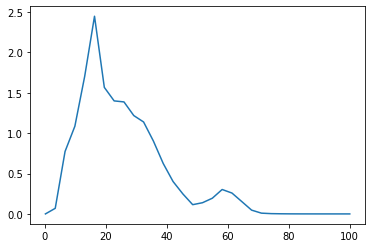

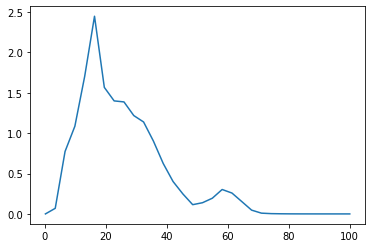

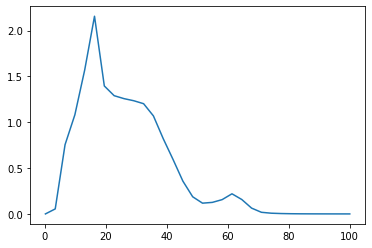

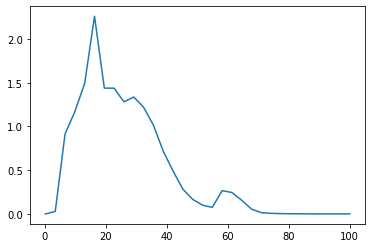

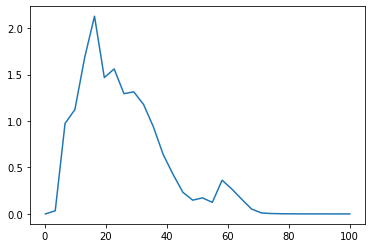

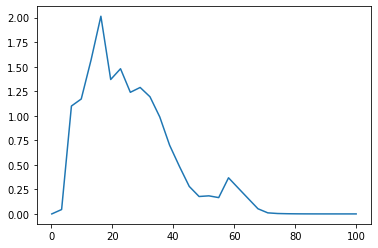

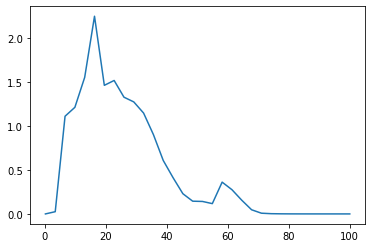

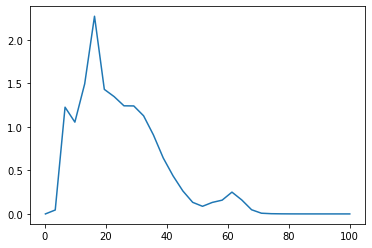

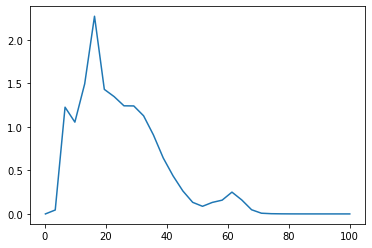

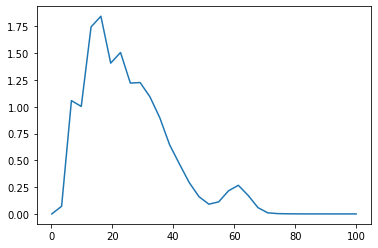

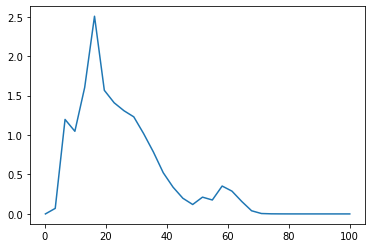

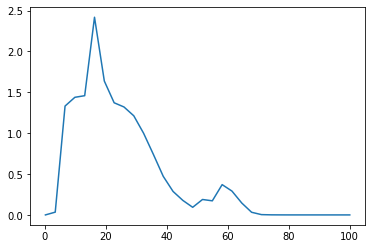

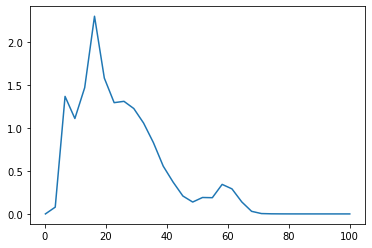

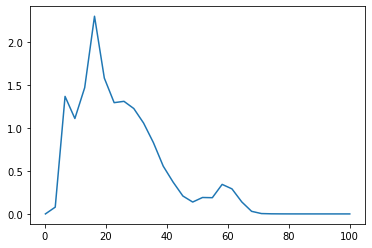

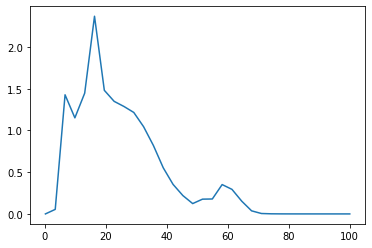

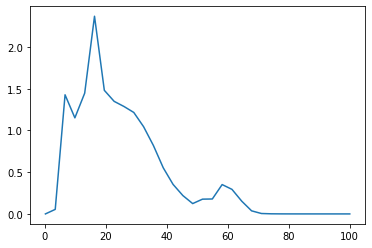

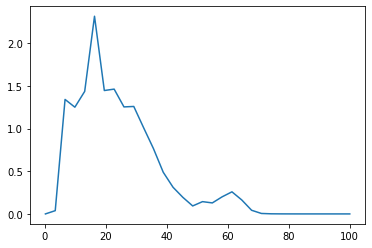

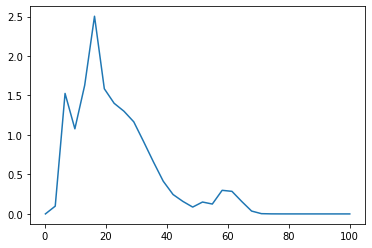

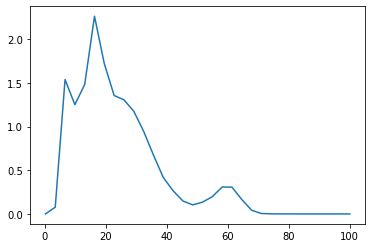

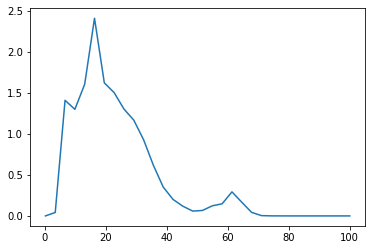

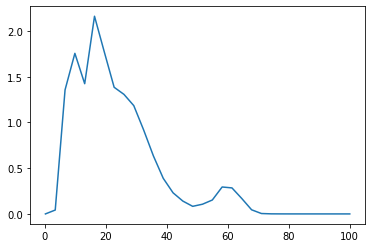

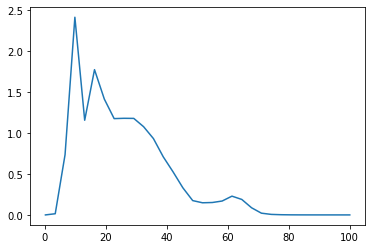

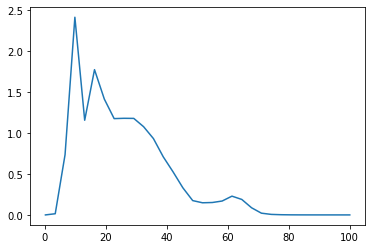

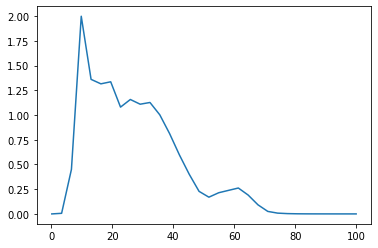

In [212]:
for i in range(len(m1_0)):
    plt.plot(axes[0], probs[i].sum((1, 2, 3)))
    plt.show()

(1e-05, 3)

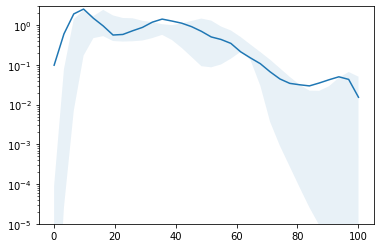

In [179]:
plt.plot(axes[0], pm1)
plt.fill_between(axes[0], m1_005, m1_095, alpha=0.1)
plt.yscale('log')
plt.ylim((1e-5, 3))